In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.special import expit

In [2]:
data_dir = "data"

In [3]:
Z0 = np.load(f"{data_dir}/Z0.npy")
Y0 = np.load(f"{data_dir}/Y0.npy")

In [4]:
est_A = np.load(f"{data_dir}/est_A0.npy")
est_b = np.load(f"{data_dir}/est_b0.npy")
est_Z = np.load(f"{data_dir}/est_Z0.npy")

In [5]:
def calc_grad(with_prior=True):
    P_cm = expit(Z0 @ est_A.T + est_b)
    
    if with_prior:
        return (Y0 - P_cm) @ est_A - Z0
    else:
        return (Y0 - P_cm) @ est_A
    
def get_center(interval: pd.Interval):
    left = interval.right*2 if np.isinf(interval.left) else interval.left
    right = interval.left*2 if np.isinf(interval.right) else interval.right
    
    return (left + right) / 2.0

def draw_arrow(ax, x1: np.ndarray, x2:np.ndarray):
    ax.annotate(
        '',
        xy=x2, # end
        xytext=x1, # start
        arrowprops=dict(
            shrink=0,
            width=1,
            headwidth=5,
            headlength=10,
            connectionstyle='arc3',
            facecolor='black',
            edgecolor='black'
        )
    )

In [6]:
Z_df = pd.DataFrame(Z0, columns=["s1", "s2"])
est_Z_df = pd.DataFrame(est_Z, columns=["est_s1", "est_s2"])
grad_df = pd.DataFrame(calc_grad(), columns=["grad1", "grad2"])

join_df = pd.concat([Z_df, est_Z_df, grad_df], axis=1)
join_df["diff1"] = join_df["est_s1"] - join_df["s1"]
join_df["diff2"] = join_df["est_s2"] - join_df["s2"]

cuts = [norm.ppf(x) for x in [0, 0.25, 0.5, 0.75, 1.0]]
join_df["class1"] = pd.cut(join_df["s1"], cuts)
join_df["class2"] = pd.cut(join_df["s2"], cuts)

group_df = join_df \
    .groupby(by=["class1", "class2"]) \
    .agg({
        "diff1": ["mean", "count"],
        "diff2": ["mean", "count"],
        "grad1": ["mean"],
        "grad2": ["mean"],
    }) 

# Fig_7_Left

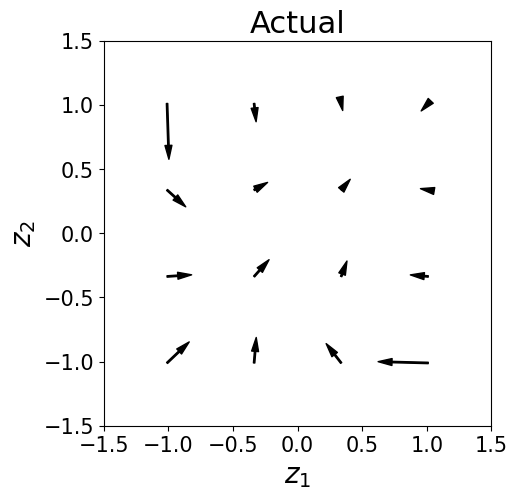

In [7]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("$z_1$", fontsize=20)
ax.set_ylabel("$z_2$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Actual", fontsize=22)

for idx in group_df.index:
    x1 = np.zeros(2)
    x2 = np.zeros(2)
    x1[0] = get_center(idx[0])
    x1[1] = get_center(idx[1])
    
    d0 = group_df.loc[idx, ("diff1", "mean")]
    d1 = group_df.loc[idx, ("diff2", "mean")]
    
    x2[0] = x1[0] + d0
    x2[1] = x1[1] + d1
    
    draw_arrow(ax, x1, x2)

# Fig_7_Right

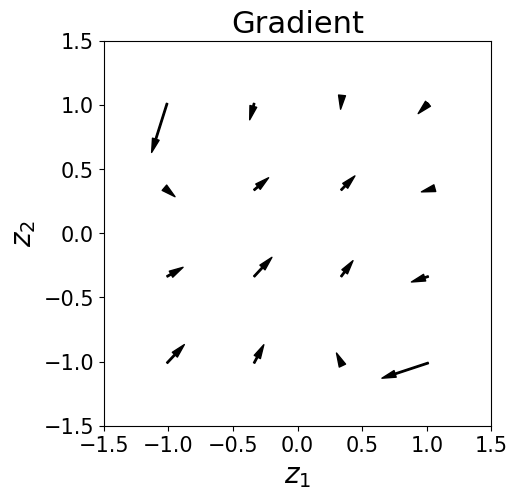

In [8]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("$z_1$", fontsize=20)
ax.set_ylabel("$z_2$", fontsize=20)

ticks_data = None
plt.xticks(ticks=ticks_data, fontsize=15)
plt.yticks(ticks=ticks_data, fontsize=15)
plt.title("Gradient", fontsize=22)

scale1 = group_df.loc[:, ("grad1", "mean")].abs().mean() / group_df.loc[:, ("diff1", "mean")].abs().mean() 
scale2 = group_df.loc[:, ("grad2", "mean")].abs().mean() / group_df.loc[:, ("diff2", "mean")].abs().mean()

for idx in group_df.index:
    x1 = np.zeros(2)
    x2 = np.zeros(2)
    x1[0] = get_center(idx[0])
    x1[1] = get_center(idx[1])
    
    d0 = group_df.loc[idx, ("grad1", "mean")] / scale1
    d1 = group_df.loc[idx, ("grad2", "mean")] / scale2
    
    x2[0] = x1[0] + d0
    x2[1] = x1[1] + d1
    
    draw_arrow(ax, x1, x2)

# Table 1

In [9]:
ctab1 = pd.crosstab(index=join_df["class1"], columns=join_df["class2"], values=join_df["diff1"], aggfunc="mean").T
ctab1 = ctab1.sort_index(ascending=False)
ctab1

class1,"(-inf, -0.674]","(-0.674, 0.0]","(0.0, 0.674]","(0.674, inf]"
class2,,,,
"(0.674, inf]",0.014231,0.015302,0.011779,-0.054690
"(0.0, 0.674]",0.144550,0.104312,0.070076,-0.060216
"(-0.674, 0.0]",0.190267,0.115742,0.044851,-0.138642
"(-inf, -0.674]",0.171580,0.016357,-0.116432,-0.388073


# Table 2

In [10]:
ctab2 = pd.crosstab(index=join_df["class1"], columns=join_df["class2"], values=join_df["diff2"], aggfunc="mean").T
ctab2 = ctab2.sort_index(ascending=False)
ctab2

class1,"(-inf, -0.674]","(-0.674, 0.0]","(0.0, 0.674]","(0.674, inf]"
class2,,,,
"(0.674, inf]",-0.434917,-0.142366,-0.054732,-0.058163
"(0.0, 0.674]",-0.131234,0.058901,0.083280,0.010350
"(-0.674, 0.0]",0.012895,0.130841,0.120360,0.012283
"(-inf, -0.674]",0.164144,0.198627,0.150865,0.010119


# Table 3

In [11]:
ctab_grad1 = pd.crosstab(index=join_df["class1"], columns=join_df["class2"], values=join_df["grad1"], aggfunc="mean").T
ctab_grad1 = ctab_grad1.sort_index(ascending=False)
ctab_grad1

class1,"(-inf, -0.674]","(-0.674, 0.0]","(0.0, 0.674]","(0.674, inf]"
class2,,,,
"(0.674, inf]",-1.712455,-0.491306,-0.065468,-1.115680
"(0.0, 0.674]",0.883383,1.609186,1.525407,-0.758472
"(-0.674, 0.0]",1.776553,1.974394,1.311884,-1.867273
"(-inf, -0.674]",1.919843,1.078472,-0.520309,-5.138920


# Table 4

In [12]:
ctab_grad2 = pd.crosstab(index=join_df["class1"], columns=join_df["class2"], values=join_df["grad2"], aggfunc="mean").T
ctab_grad2 = ctab_grad2.sort_index(ascending=False)
ctab_grad2

class1,"(-inf, -0.674]","(-0.674, 0.0]","(0.0, 0.674]","(0.674, inf]"
class2,,,,
"(0.674, inf]",-5.188054,-1.728852,-0.608444,-1.072515
"(0.0, 0.674]",-0.713800,1.298507,1.492514,-0.200831
"(-0.674, 0.0]",0.972100,2.028839,1.675343,-0.584733
"(-inf, -0.674]",1.948954,1.934394,1.053571,-1.614996
